In [ ]:
import json
import os

import numpy as np
import pandas as pd
import quapy as qp
import matplotlib.pyplot as plt

import utils

In [39]:
pd.set_option('display.precision', 3)
random_state = 42
n_jobs = -1
qp.environ['N_JOBS'] = n_jobs

In [40]:
test_name = "09"

read_config_filename = f"config_{test_name}.json"
write_config_filename = None

if not read_config_filename and write_config_filename:
    config = {
        'populations': {
            'F': {
                'n_features': 2,
                'n_informative': 2,
                'n_redundant': 0,
                'n_repeated': 0,
                'n_classes': 2,
                'flip_y': 0,
                'class_sep': 0.6,
            },
            'D': {
                'n_features': 100,
                'n_informative': 5,
                'n_redundant': 15,
                'n_repeated': 15,
                'n_classes': 2,
                'flip_y': 0,    
                'class_sep': 0.2,
            },
        },
        'trainset': {
            'total_size': 50000,
            'sample_sizes': [
                500,
                5000,
            ],
            'n_prevalences': 5,
            'repeats': 5,
        },
        'testset': {
            'total_size': 1000,
            'sample_sizes': [
                10,
                100,
            ],
            'n_prevalences': 5,
            'repeats': 5,
        },
        'classification': {
            'models': [
                # 'GaussianNB', # Generative, Simple
                # 'ComplementNB', # Generative, Complex
                'LogisticRegression', # Discriminative, Simple
                'XGBClassifier', # Discriminative, Complex
            ],
            'metrics': {
                'labels': [
                    'f1_score',
                ],
                'scores': [
                    'ece',
                ],
            },
        },
        'calibration': {
            'methods': [
                'No Calibration',
                #'NBVSCalibration',
                #'BCTSCalibration',
                #'TSCalibration',
                #'VSCalibration',
                'PlattScaling',
                'HistogramCalibration',
                'IsotonicCalibration',
                'BBQCalibration',
                #'BetaCalibration',
            ],
            'val_split': 0.2,
        },
        'quantification': {
            'methods': [
                'CC',
                'ACC',
                'PCC',
                'PACC',
                'TH_MAX',
                'TH_X',
                'TH_T50',
                'TH_MS',
                'EMQ',
                'HDy',
                'HDx',
                'newSVMKLD',
                'newSVMAE',
                'newSVMRAE',
                'LR-Implicit',
            ],
            'val_split': {
                'ACC': 0.2,
                'PACC': 0.2,
                'TH_MAX': 0.2,
                'TH_X': 0.2,
                'TH_T50': 0.2,
                'TH_MS': 0.2,
                'HDy': 0.2,
            },
            'metrics': [
                'ae',
                'se',
                'rae',
            ],
        },
    }
    exist_ok = True
    os.makedirs(f"experiments/", exist_ok=exist_ok)
    with open(f"experiments/{write_config_filename}", 'w+') as fp:
       json.dump(config, fp)
elif read_config_filename and not write_config_filename:
    f = open(f"experiments/{read_config_filename}")
    config = json.load(f)
        

In [ ]:
if not read_config_filename and write_config_filename:
    stats_df = utils.run_sequence(config, n_jobs, random_state, with_eval=True)
    stats_df.to_pickle(f"experiments/stats_{test_name}.pkl")
elif read_config_filename and not write_config_filename:
    stats_df = pd.read_pickle(f"experiments/stats_{test_name}.pkl")

In [42]:
stats_df['Quantifier'] = stats_df['Quantifier'].str.replace('ELM - SVM' ,'ELM-SVMperf')

In [43]:
# Los casos en los que falló el entrenamiento:
stats_df[stats_df['Test sample size'].isna()]

,Population,Train sample size,Train prev,Test prev,Test sample size,Classifier,Calibration,Quantifier,Estim test prev,f1_score,ece,ae,se,rae


In [44]:
stats_df = stats_df[stats_df['Test sample size'].notnull()]

In [ ]:
parsed_stats = utils.parse_stats(stats_df)

In [46]:
quant_metric_cols = ['RAE', 'AE', 'SE']
clasi_metric_cols = ['F1']
calib_metric_cols = ['ECE']
all_metrics = quant_metric_cols + clasi_metric_cols + calib_metric_cols

In [ ]:
group_cols = ['Cuantificador']
metric_cols = quant_metric_cols
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats)
by_quantifier = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_quantifier.to_latex('./experiments/tables/by_quantifier.tex', bold_rows=True, multicolumn=False)
by_quantifier


RAE                   AE                   SE              
               media      (      )  media      (      )  media      (      )
Cuantificador                                                               
TH_MS          2.102  1.995  2.208  0.224  0.219  0.229  0.120  0.115  0.124
TH_T50         2.172  2.065  2.279  0.251  0.246  0.257  0.140  0.135  0.144
TH_MAX         2.186  2.085  2.287  0.232  0.227  0.237  0.118  0.114  0.122
TH_X           2.305  2.193  2.418  0.245  0.240  0.250  0.133  0.128  0.138
LR-Implicit    2.361  2.314  2.408  0.239  0.237  0.241  0.122  0.120  0.124
EMQ            2.382  2.331  2.433  0.254  0.252  0.257  0.142  0.140  0.144
PACC           2.399  2.353  2.445  0.231  0.229  0.234  0.112  0.110  0.114
HDx            2.716  2.544  2.888  0.272  0.264  0.279  0.146  0.140  0.153
ACC            2.887  2.775  2.999  0.255  0.250  0.260  0.125  0.121  0.129
HDy            2.958  2.899  3.018  0.302  0.299  0.304  0.185  0.183  0.188
CC             3.909  3.757  4.061  0.362  0.356  0.368  0.228  0.222  0.234
PCC            3.987  3.923  4.051  0.341  0.338  0.343  0.196  0.194  0.198
ELM-SVMKLD     4.569  4.335  4.803  0.407  0.398  0.416  0.271  0.262  0.280
ELM-SVMAE      4.638  4.394  4.882  0.428  0.419  0.437  0.296  0.286  0.305
ELM-SVMRAE     4.724  4.473  4.975  0.440  0.430  0.449  0.312  0.302  0.321

In [ ]:
group_cols = ['Clasificador']
metric_cols = quant_metric_cols + clasi_metric_cols
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats[parsed_stats['Clasificador'] != '-'])
by_classifier = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_classifier.to_latex('./experiments/tables/by_classifier.tex', bold_rows=True, multicolumn=False)
by_classifier

RAE                   AE                  SE         \
                    media      (      )  media      (      ) media      (   
Clasificador                                                                
XGBClassifier       2.308  2.281  2.336  0.232  0.231  0.233  0.12  0.119   
LogisticRegression  3.240  3.207  3.273  0.310  0.309  0.312  0.18  0.179   

                              F1                
                        )  media      (      )  
Clasificador                                    
XGBClassifier       0.121  0.517  0.516  0.519  
LogisticRegression  0.181  0.384  0.382  0.386

In [ ]:
group_cols = ['Population']
metric_cols = quant_metric_cols
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats)
by_population = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_population.to_latex('./experiments/tables/by_population.tex', bold_rows=True, multicolumn=False)
by_population

RAE                   AE                   SE              
            media      (      )  media      (      )  media      (      )
Population                                                               
F           2.324  2.298  2.350  0.236  0.235  0.238  0.120  0.119  0.121
D           3.392  3.358  3.426  0.320  0.318  0.321  0.193  0.191  0.194

In [ ]:
group_cols = ['Train n_samples']
metric_cols = quant_metric_cols
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats)
by_train_sample_size = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_train_sample_size.to_latex('./experiments/tables/by_train_sample_size.tex', bold_rows=True, multicolumn=False)
by_train_sample_size

RAE                   AE                   SE              
                 media      (      )  media      (      )  media      (      )
Train n_samples                                                               
5000             2.431  2.403  2.458  0.248  0.246  0.249  0.134  0.132  0.135
500              3.286  3.253  3.318  0.309  0.307  0.310  0.179  0.178  0.180

In [ ]:
group_cols = ['Test n_samples']
metric_cols = quant_metric_cols
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats)
by_test_sample_size = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_test_sample_size.to_latex('./experiments/tables/by_test_sample_size.tex', bold_rows=True, multicolumn=False)
by_test_sample_size

RAE                   AE                   SE              
                media      (      )  media      (      )  media      (      )
Test n_samples                                                               
10              1.731  1.718  1.744  0.301  0.300  0.303  0.175  0.174  0.176
100             3.986  3.945  4.026  0.255  0.253  0.256  0.138  0.137  0.139

In [ ]:
group_cols = ['Train prev +']
metric_cols = quant_metric_cols
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats)
by_train_prev = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_train_prev.to_latex('./experiments/tables/by_train_prev.tex', bold_rows=True, multicolumn=False)
by_train_prev

RAE                   AE                   SE              
              media      (      )  media      (      )  media      (      )
Train prev +                                                               
0.50          1.865  1.833  1.896  0.180  0.179  0.182  0.073  0.072  0.074
0.25          2.105  2.067  2.142  0.220  0.218  0.222  0.106  0.104  0.107
0.75          2.162  2.124  2.199  0.217  0.216  0.219  0.103  0.102  0.105
0.01          4.037  3.977  4.098  0.382  0.380  0.385  0.246  0.244  0.248
0.99          4.123  4.061  4.184  0.390  0.387  0.392  0.254  0.252  0.256

In [ ]:
group_cols = ['Test prev +']
metric_cols = quant_metric_cols
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats)
by_test_prev = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_test_prev.to_latex('./experiments/tables/by_test_prev.tex', bold_rows=True, multicolumn=False)
by_test_prev

RAE                   AE                   SE              
             media      (      )  media      (      )  media      (      )
Test prev +                                                               
0.50         0.492  0.489  0.495  0.260  0.259  0.262  0.104  0.103  0.105
0.25         0.624  0.618  0.630  0.238  0.236  0.240  0.104  0.102  0.106
0.75         0.699  0.693  0.706  0.267  0.264  0.269  0.127  0.125  0.129
0.20         0.718  0.712  0.724  0.277  0.275  0.280  0.128  0.126  0.130
0.80         0.806  0.798  0.813  0.311  0.308  0.314  0.164  0.161  0.166
1.00         3.230  3.188  3.272  0.308  0.304  0.312  0.232  0.228  0.236
0.00         3.378  3.338  3.419  0.322  0.319  0.326  0.232  0.228  0.236
0.01         8.627  8.508  8.745  0.255  0.251  0.258  0.170  0.167  0.173
0.99         9.517  9.390  9.643  0.281  0.278  0.285  0.199  0.196  0.203

In [ ]:
group_cols = ['Abs Dataset Shift']
metric_cols = quant_metric_cols
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats)
by_abs_dataset_shift = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_abs_dataset_shift.to_latex('./experiments/tables/by_abs_dataset_shift.tex', bold_rows=True, multicolumn=False)
by_abs_dataset_shift

RAE                    AE                   SE         \
                   media      (       )  media      (      )  media      (   
Abs Dataset Shift                                                            
(0-0.25]           1.100  1.085   1.114  0.191  0.190  0.192  0.078  0.077   
(0.25-0.5]         1.774  1.747   1.800  0.259  0.258  0.261  0.117  0.116   
[0]                1.846  1.790   1.902  0.139  0.137  0.141  0.058  0.056   
(0.5-0.75]         3.878  3.822   3.933  0.361  0.359  0.364  0.220  0.218   
(0.75-1.0]         9.956  9.844  10.067  0.604  0.601  0.607  0.484  0.480   

                          
                       )  
Abs Dataset Shift         
(0-0.25]           0.079  
(0.25-0.5]         0.118  
[0]                0.059  
(0.5-0.75]         0.222  
(0.75-1.0]         0.487

In [ ]:
group_cols = ['Abs Dataset Shift', 'Cuantificador']
metric_cols = quant_metric_cols
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats)
by_abs_dataset_shift_and_quantificator = summary[metric_cols].sort_values(by=['Abs Dataset Shift', (('RAE', 'media'))], ascending=True)
by_abs_dataset_shift_and_quantificator.to_latex('./experiments/tables/by_abs_dataset_shift_and_quantificator.tex', bold_rows=True, multicolumn=False)
by_abs_dataset_shift_and_quantificator

RAE                     AE                \
                                  media       (       )  media      (      )   
Abs Dataset Shift Cuantificador                                                
[0]               PCC             0.070   0.067   0.072  0.020  0.020  0.021   
                  CC              0.269   0.259   0.280  0.074  0.069  0.078   
                  HDx             0.293   0.270   0.315  0.090  0.081  0.099   
                  ELM-SVMKLD      0.307   0.291   0.323  0.086  0.078  0.093   
                  ELM-SVMAE       0.348   0.332   0.364  0.101  0.093  0.109   
...                                 ...     ...     ...    ...    ...    ...   
(0.75-1.0]        PCC            14.486  14.165  14.807  0.877  0.874  0.880   
                  CC             14.692  13.964  15.421  0.889  0.882  0.897   
                  ELM-SVMAE      15.348  14.282  16.414  0.930  0.923  0.937   
                  ELM-SVMKLD     15.348  14.282  16.414  0.930  0.923  0.937   
                  ELM-SVMRAE     15.348  14.282  16.414  0.930  0.923  0.937   

                                    SE                
                                 media      (      )  
Abs Dataset Shift Cuantificador                       
[0]               PCC            0.001  0.001  0.001  
                  CC             0.013  0.011  0.014  
                  HDx            0.021  0.017  0.025  
                  ELM-SVMKLD     0.017  0.014  0.019  
                  ELM-SVMAE      0.020  0.018  0.023  
...                                ...    ...    ...  
(0.75-1.0]        PCC            0.786  0.781  0.791  
                  CC             0.809  0.797  0.822  
                  ELM-SVMAE      0.873  0.860  0.887  
                  ELM-SVMKLD     0.873  0.860  0.887  
                  ELM-SVMRAE     0.873  0.860  0.887  

[75 rows x 9 columns]

In [ ]:
group_cols = ['Calibración']
metric_cols = all_metrics
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats[parsed_stats['Calibración'] != '-'])
by_calibration = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_calibration.to_latex('./experiments/tables/by_calibration.tex', bold_rows=True, multicolumn=False)
by_calibration

RAE                   AE                   SE         \
                      media      (      )  media      (      )  media      (   
Calibración                                                                    
IsotonicCalibration   2.570  2.519  2.621  0.255  0.252  0.257  0.136  0.134   
No Calibration        2.730  2.677  2.782  0.273  0.270  0.275  0.150  0.147   
PlattScaling          2.850  2.795  2.905  0.279  0.276  0.281  0.156  0.154   
BBQCalibration        2.951  2.895  3.007  0.281  0.279  0.284  0.159  0.157   
HistogramCalibration  2.987  2.931  3.042  0.279  0.277  0.282  0.156  0.154   

                                F1                   ECE                  
                          )  media      (      )   media       (       )  
Calibración                                                               
IsotonicCalibration   0.138  0.449  0.445  0.452  32.787  32.546  33.028  
No Calibration        0.152  0.455  0.452  0.459  32.554  32.309  32.799  
PlattScaling          0.158  0.451  0.447  0.454  31.715  31.471  31.959  
BBQCalibration        0.162  0.449  0.446  0.453  33.197  32.943  33.451  
HistogramCalibration  0.158  0.450  0.446  0.453  33.853  33.608  34.097

In [ ]:
group_cols = ['Cuantificador', 'Calibración']
metric_cols = all_metrics
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats)
by_quantifier_and_calibration = summary[metric_cols].sort_values(by=[(('RAE', 'media'))], ascending=True)
by_quantifier_and_calibration.to_latex('./experiments/tables/by_quantifier_and_calibration.tex', bold_rows=True, multicolumn=False)
by_quantifier_and_calibration

RAE                   AE                \
                                    media      (      )  media      (      )   
Cuantificador Calibración                                                      
LR-Implicit   IsotonicCalibration   2.096  1.998  2.195  0.219  0.214  0.224   
TH_MS         -                     2.102  1.995  2.208  0.224  0.219  0.229   
EMQ           IsotonicCalibration   2.104  2.005  2.203  0.218  0.213  0.223   
              No Calibration        2.130  2.031  2.228  0.239  0.234  0.244   
TH_T50        -                     2.172  2.065  2.279  0.251  0.246  0.257   
PACC          IsotonicCalibration   2.183  2.080  2.286  0.233  0.228  0.238   
TH_MAX        -                     2.186  2.085  2.287  0.232  0.227  0.237   
PACC          PlattScaling          2.188  2.088  2.289  0.229  0.224  0.234   
LR-Implicit   No Calibration        2.193  2.092  2.294  0.244  0.239  0.249   
PACC          No Calibration        2.227  2.123  2.331  0.229  0.224  0.234   
TH_X          -                     2.305  2.193  2.418  0.245  0.240  0.250   
LR-Implicit   PlattScaling          2.424  2.310  2.537  0.253  0.248  0.258   
              BBQCalibration        2.444  2.337  2.552  0.243  0.238  0.248   
EMQ           PlattScaling          2.464  2.349  2.578  0.256  0.251  0.262   
HDy           IsotonicCalibration   2.551  2.431  2.672  0.270  0.265  0.276   
EMQ           BBQCalibration        2.574  2.446  2.703  0.281  0.275  0.287   
              HistogramCalibration  2.639  2.515  2.762  0.277  0.271  0.282   
LR-Implicit   HistogramCalibration  2.647  2.543  2.751  0.235  0.230  0.239   
PACC          HistogramCalibration  2.653  2.547  2.759  0.238  0.233  0.242   
HDx           -                     2.716  2.544  2.888  0.272  0.264  0.279   
PACC          BBQCalibration        2.744  2.643  2.845  0.229  0.224  0.233   
HDy           BBQCalibration        2.881  2.743  3.018  0.303  0.297  0.309   
ACC           -                     2.887  2.775  2.999  0.255  0.250  0.260   
HDy           HistogramCalibration  2.950  2.812  3.087  0.304  0.298  0.310   
              No Calibration        3.142  3.008  3.275  0.311  0.305  0.317   
              PlattScaling          3.269  3.134  3.403  0.319  0.313  0.325   
PCC           PlattScaling          3.906  3.765  4.048  0.337  0.331  0.342   
CC            -                     3.909  3.757  4.061  0.362  0.356  0.368   
PCC           IsotonicCalibration   3.914  3.775  4.054  0.333  0.328  0.339   
              No Calibration        3.957  3.814  4.100  0.340  0.335  0.346   
              HistogramCalibration  4.046  3.902  4.190  0.344  0.338  0.349   
              BBQCalibration        4.112  3.967  4.258  0.349  0.344  0.355   
ELM-SVMKLD    -                     4.569  4.335  4.803  0.407  0.398  0.416   
ELM-SVMAE     -                     4.638  4.394  4.882  0.428  0.419  0.437   
ELM-SVMRAE    -                     4.724  4.473  4.975  0.440  0.430  0.449   

                                       SE                   F1                \
                                    media      (      )  media      (      )   
Cuantificador Calibración                                                      
LR-Implicit   IsotonicCalibration   0.109  0.105  0.113  0.451  0.443  0.458   
TH_MS         -                     0.120  0.115  0.124  0.451  0.444  0.459   
EMQ           IsotonicCalibration   0.107  0.103  0.111  0.451  0.443  0.458   
              No Calibration        0.122  0.117  0.126  0.458  0.450  0.465   
TH_T50        -                     0.140  0.135  0.144  0.451  0.444  0.459   
PACC          IsotonicCalibration   0.119  0.114  0.123  0.446  0.439  0.454   
TH_MAX        -                     0.118  0.114  0.122  0.449  0.442  0.457   
PACC          PlattScaling          0.116  0.111  0.120  0.446  0.439  0.454   
LR-Implicit   No Calibration        0.126  0.122  0.130  0.458  0.450  0.465   
PACC          No Calibration        0

In [ ]:
group_cols = ['Train prev +', 'Calibración']
metric_cols = all_metrics
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats[parsed_stats['Calibración'] != '-'])
by_train_prev_and_calibration = summary[metric_cols].sort_values(by=['Train prev +', (('RAE', 'media'))], ascending=True)
by_train_prev_and_calibration.to_latex('./experiments/tables/by_train_prev_and_calibration.tex', bold_rows=True, multicolumn=False)
by_train_prev_and_calibration

RAE                   AE                \
                                   media      (      )  media      (      )   
Train prev + Calibración                                                      
0.01         IsotonicCalibration   3.575  3.430  3.720  0.352  0.346  0.358   
             No Calibration        3.902  3.748  4.055  0.391  0.385  0.397   
             PlattScaling          4.018  3.860  4.175  0.387  0.381  0.394   
             BBQCalibration        4.376  4.217  4.536  0.391  0.385  0.397   
             HistogramCalibration  4.398  4.238  4.557  0.392  0.386  0.398   
0.25         IsotonicCalibration   1.828  1.747  1.909  0.192  0.188  0.196   
             BBQCalibration        1.909  1.821  1.997  0.206  0.202  0.211   
             HistogramCalibration  2.010  1.922  2.098  0.205  0.201  0.209   
             No Calibration        2.069  1.980  2.159  0.213  0.209  0.218   
             PlattScaling          2.113  2.022  2.204  0.219  0.214  0.223   
0.50         No Calibration        1.789  1.712  1.865  0.171  0.167  0.175   
             IsotonicCalibration   1.791  1.711  1.871  0.179  0.175  0.183   
             BBQCalibration        1.821  1.739  1.903  0.181  0.177  0.185   
             PlattScaling          1.869  1.788  1.950  0.178  0.174  0.182   
             HistogramCalibration  1.874  1.793  1.954  0.183  0.179  0.187   
0.75         IsotonicCalibration   1.904  1.820  1.988  0.189  0.185  0.193   
             HistogramCalibration  2.056  1.969  2.143  0.203  0.198  0.207   
             BBQCalibration        2.080  1.987  2.172  0.209  0.204  0.213   
             No Calibration        2.081  1.993  2.168  0.207  0.203  0.212   
             PlattScaling          2.150  2.059  2.242  0.215  0.210  0.219   
0.99         IsotonicCalibration   3.752  3.601  3.902  0.361  0.354  0.367   
             No Calibration        3.808  3.656  3.960  0.381  0.375  0.387   
             PlattScaling          4.101  3.942  4.260  0.396  0.390  0.402   
             BBQCalibration        4.570  4.403  4.736  0.418  0.412  0.424   
             HistogramCalibration  4.597  4.432  4.762  0.414  0.408  0.420   

                                      SE                   F1                \
                                   media      (      )  media      (      )   
Train prev + Calibración                                                      
0.01         IsotonicCalibration   0.217  0.211  0.222  0.075  0.071  0.078   
             No Calibration        0.255  0.249  0.261  0.083  0.079  0.087   
             PlattScaling          0.252  0.246  0.258  0.079  0.075  0.083   
             BBQCalibration        0.250  0.244  0.256  0.078  0.074  0.082   
             HistogramCalibration  0.251  0.245  0.257  0.075  0.071  0.079   
0.25         IsotonicCalibration   0.082  0.078  0.085  0.351  0.345  0.358   
             BBQCalibration        0.096  0.092  0.099  0.350  0.344  0.357   
             HistogramCalibration  0.092  0.088  0.095  0.354  0.347  0.360   
             No Calibration        0.095  0.092  0.099  0.371  0.364  0.377   
             PlattScaling          0.100  0.096  0.103  0.353  0.347  0.360   
0.50         No Calibration        0.065  0.062  0.068  0.579  0.573  0.586   
             IsotonicCalibration   0.073  0.070  0.077  0.576  0.569  0.582   
             BBQCalibration        0.075  0.072  0.079  0.577  0.571  0.583   
             PlattScaling          0.072  0.069  0.075  0.578  0.572  0.585   
             HistogramCalibration  0.075  0.072  0.078  0.577  0.571  0.584   
0.75         IsotonicCalibration   0.081  0.077  0.084  0.614  0.607  0.621   
             HistogramCalibration  0.090  0.086  0.093  0.614  0.607  0.621   
             BBQCalibration        0.096  0.092  0.100  0.614  0.607  0.621   
             No Calibration        0.088  0.085  0.092  0.616  0.609  0.623   
             PlattScaling          0.096  0.093  0.100  0.615  0.608  0.622   
0.99   

In [ ]:
group_cols = ['Abs Dataset Shift', 'Calibración']
metric_cols = all_metrics
summary = utils.create_ci_cols(group_cols, metric_cols, parsed_stats[parsed_stats['Calibración'] != '-'])
summary[metric_cols].sort_values(by=['Abs Dataset Shift', (('RAE', 'media'))], ascending=True)

RAE                     AE         \
                                         media       (       )  media      (   
Abs Dataset Shift Calibración                                                  
[0]               IsotonicCalibration    1.096   0.995   1.196  0.113  0.109   
                  No Calibration         1.281   1.166   1.396  0.113  0.109   
                  PlattScaling           1.318   1.203   1.433  0.119  0.115   
                  BBQCalibration         3.091   2.897   3.285  0.176  0.170   
                  HistogramCalibration   3.315   3.111   3.519  0.176  0.170   
(0-0.25]          IsotonicCalibration    1.029   0.991   1.066  0.170  0.167   
                  PlattScaling           1.030   0.995   1.066  0.181  0.178   
                  No Calibration         1.049   1.013   1.084  0.187  0.184   
                  HistogramCalibration   1.254   1.216   1.292  0.208  0.205   
                  BBQCalibration         1.261   1.220   1.303  0.208  0.205   
(0.25-0.5]        IsotonicCalibration    1.686   1.619   1.753  0.248  0.244   
                  BBQCalibration         1.707   1.638   1.775  0.246  0.242   
                  No Calibration         1.744   1.680   1.807  0.268  0.265   
                  HistogramCalibration   1.746   1.679   1.813  0.245  0.241   
                  PlattScaling           1.798   1.731   1.866  0.268  0.264   
(0.5-0.75]        IsotonicCalibration    3.206   3.089   3.323  0.317  0.311   
                  BBQCalibration         3.393   3.263   3.523  0.334  0.328   
                  HistogramCalibration   3.594   3.464   3.724  0.340  0.334   
                  No Calibration         3.834   3.702   3.965  0.356  0.350   
                  PlattScaling           3.954   3.819   4.088  0.370  0.364   
(0.75-1.0]        HistogramCalibration   9.529   9.252   9.806  0.585  0.576   
                  IsotonicCalibration    9.586   9.308   9.863  0.580  0.572   
                  No Calibration         9.720   9.433  10.008  0.588  0.579   
                  BBQCalibration         9.779   9.496  10.062  0.603  0.594   
                  PlattScaling          10.473  10.181  10.766  0.632  0.623   

                                                  SE                   F1  \
                                            )  media      (      )  media   
Abs Dataset Shift Calibración                                               
[0]               IsotonicCalibration   0.117  0.041  0.038  0.044  0.626   
                  No Calibration        0.118  0.041  0.038  0.045  0.634   
                  PlattScaling          0.124  0.045  0.042  0.048  0.630   
                  BBQCalibration        0.182  0.089  0.084  0.094  0.627   
                  HistogramCalibration  0.182  0.090  0.085  0.095  0.628   
(0-0.25]          IsotonicCalibration   0.173  0.064  0.062  0.066  0.593   
                  PlattScaling          0.184  0.072  0.070  0.075  0.595   
                  No Calibration        0.190  0.076  0.074  0.079  0.600   
                  HistogramCalibration  0.211  0.090  0.087  0.092  0.594   
                  BBQCalibration        0.212  0.090  0.087  0.092  0.593   
(0.25-0.5]        IsotonicCalibration   0.252  0.107  0.104  0.110  0.452   
                  BBQCalibration        0.250  0.113  0.111  0.116  0.453   
                  No Calibration        0.272  0.116  0.113  0.119  0.457   
                  HistogramCalibration  0.249  0.112  0.109  0.114  0.453   
                  PlattScaling          0.272  0.118  0.115  0.121  0.453   
(0.5-0.75]        IsotonicCalibration   0.323  0.176  0.171  0.181  0.279   
                  BBQCalibration        0.341  0.196  0.190  0.201  0.278   
                  HistogramCalibration  0.346  0.194  0.189  0.200  0.279   
                  No Calibration        0.362  0.203  0.198  0.209  0.289   
                  PlattScaling          0.376  0.217  0.212  0.222  0.280   
(0.75-1.0]        HistogramCali

In [61]:
stats_df = stats_df.rename(columns={
    'rae': 'RAE',
    'ae': 'AE',
    'se': 'SE',
    'f1_score': 'F1',
    'ece': 'ECE',
    
    'Pupulation': 'Población',
    'Train sample size': 'Train n_samples',
    'Test sample size': 'Test n_samples',
    'Classifier': 'Clasificador',
    'Calibration': 'Calibración',
    'Quantifier': 'Cuantificador',
    'Train prev class_1': 'Train prev +',
    'Test prev class_1': 'Test prev +',
    'Abs prev shift': 'Dif prev abs',
    'Abs prev shift range': 'Abs Dataset Shift',
})

In [62]:
stats_df['Cuantificador - Calibración'] = stats_df['Cuantificador'] + ' - ' + stats_df['Calibración']

In [63]:
plt.rcParams['figure.dpi'] = 140

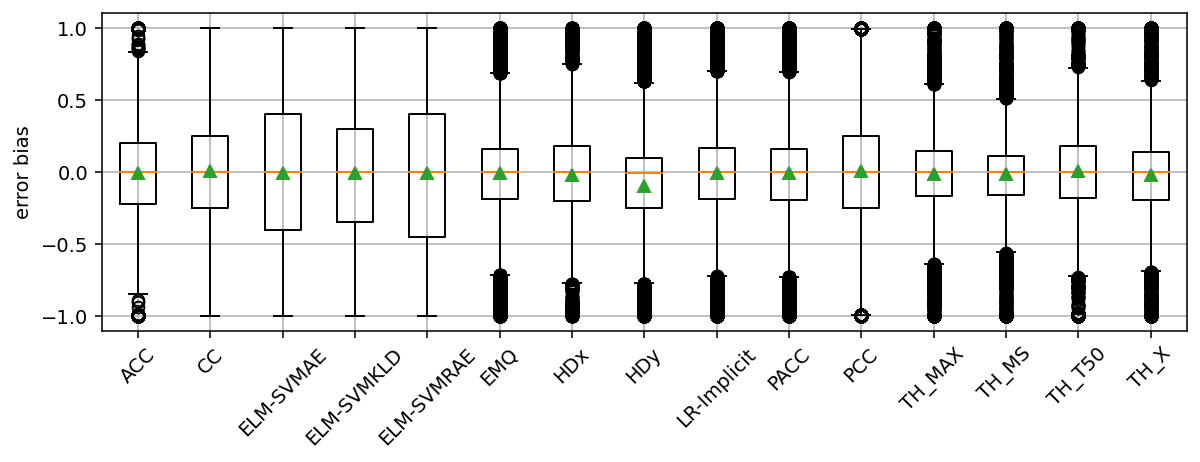

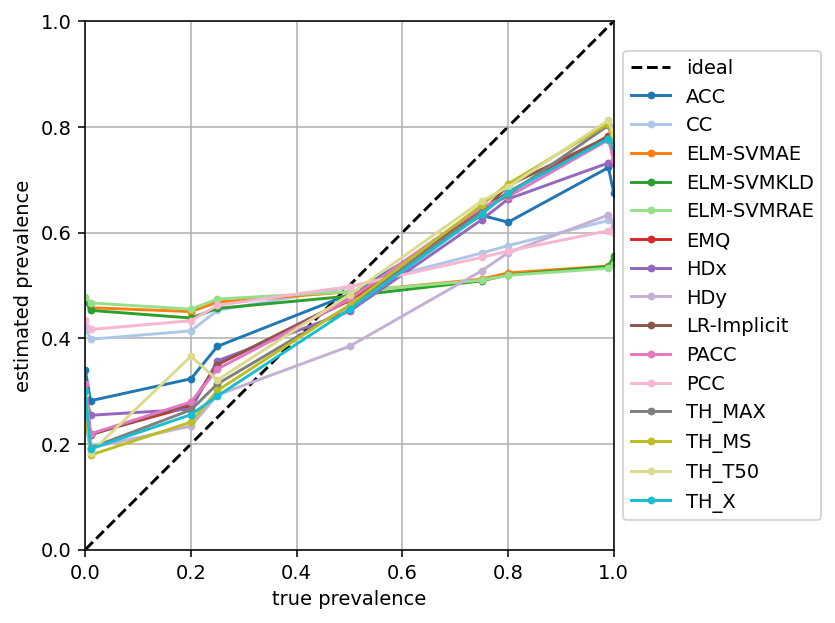

In [ ]:
groupby = ['Cuantificador']
method_names = stats_df.groupby(groupby).apply(np.array).index.tolist()
true_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Test prev'].apply(np.array)]
estim_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Estim test prev'].apply(np.array)]

plt.rcParams["figure.figsize"] = (10, 3)
qp.plot.binary_bias_global(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    savepath=f'./experiments/plots/global_bias_by_quantifier.png',
)
plt.rcParams["figure.figsize"] = (10, 5)
qp.plot.binary_diagonal(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    show_std=False,
    savepath=f'./experiments/plots/diagonal_by_cuantificator.png',
)

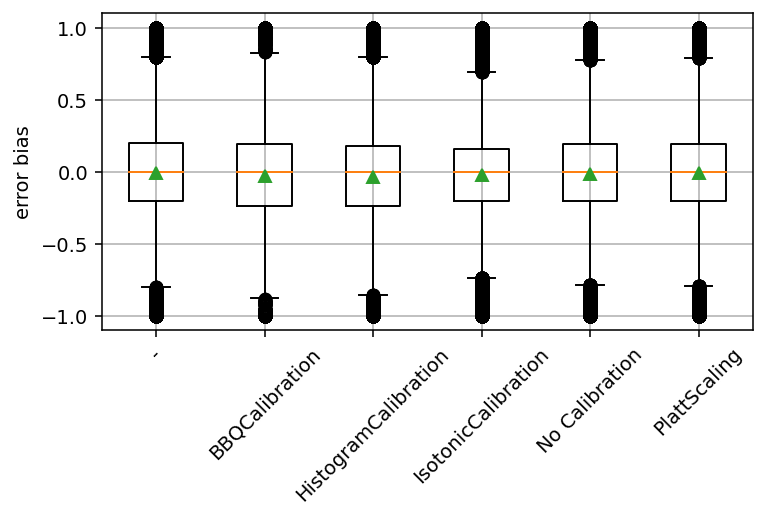

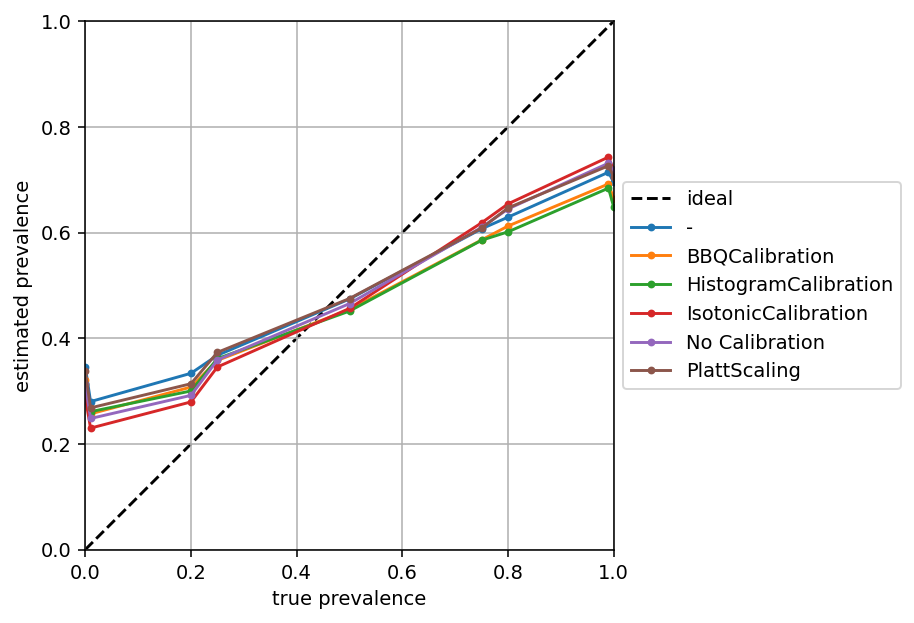

In [ ]:
groupby = ['Calibración']
method_names = stats_df.groupby(groupby).apply(np.array).index.tolist()
true_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Test prev'].apply(np.array)]
estim_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Estim test prev'].apply(np.array)]

plt.rcParams["figure.figsize"] = (6, 3)
qp.plot.binary_bias_global(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    savepath=f'./experiments/plots/global_bias_by_calibration.png',
)
plt.rcParams["figure.figsize"] = (10, 5)
qp.plot.binary_diagonal(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    show_std=False,
    savepath=f'./experiments/plots/diagonal_by_calibration.png',
)

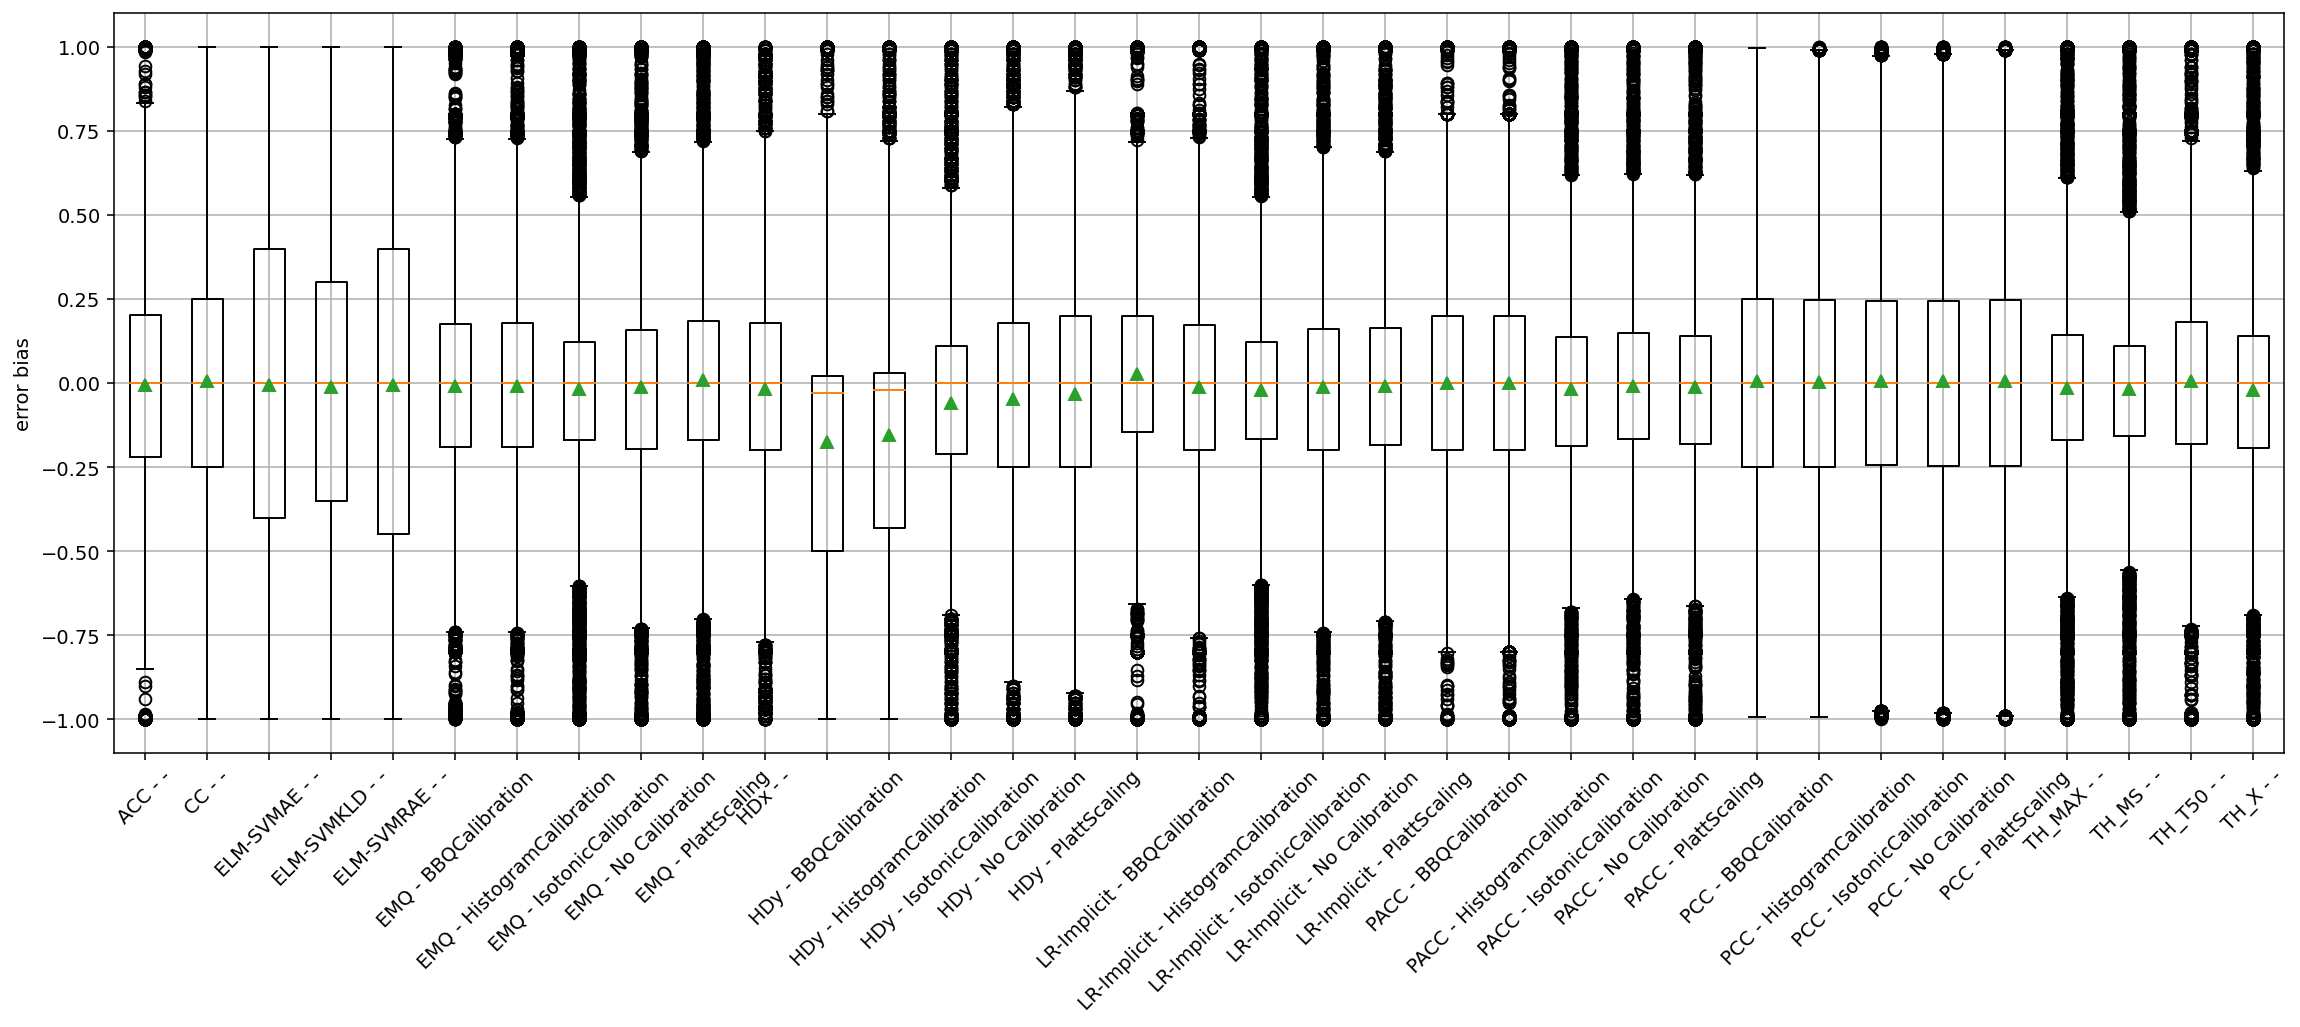

In [ ]:
groupby = ['Cuantificador - Calibración']
method_names = stats_df.groupby(groupby).apply(np.array).index.tolist()
true_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Test prev'].apply(np.array)]
estim_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Estim test prev'].apply(np.array)]

plt.rcParams["figure.figsize"] = (20, 7)
qp.plot.binary_bias_global(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    savepath=f'./experiments/plots/global_bias_by_quantifier_and_calibration.png',
)

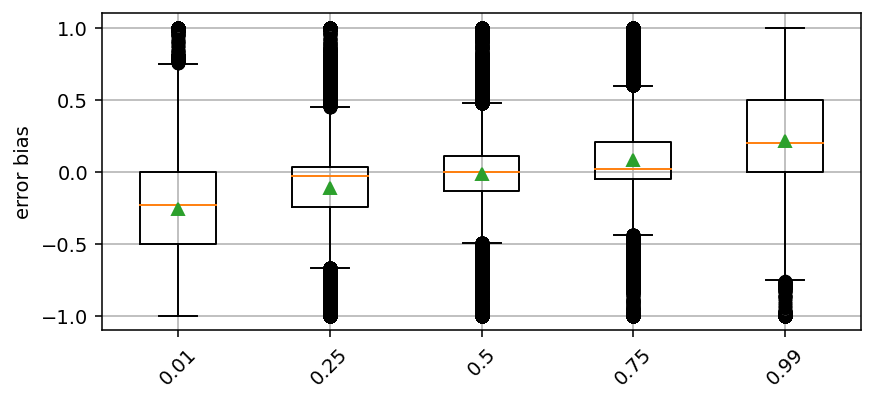

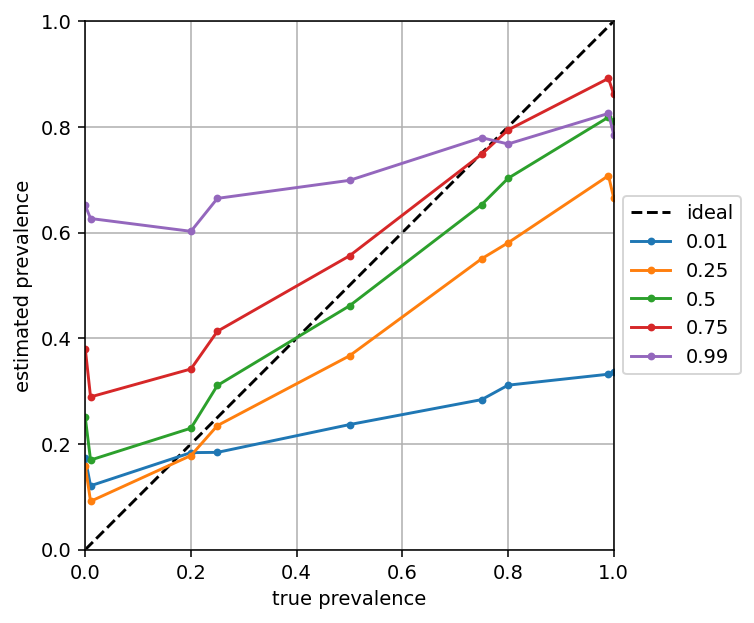

In [ ]:
groupby = ['Train prev +']
method_names = stats_df.groupby(groupby).apply(np.array).index.tolist()
true_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Test prev'].apply(np.array)]
estim_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Estim test prev'].apply(np.array)]

plt.rcParams["figure.figsize"] = (7, 3)
qp.plot.binary_bias_global(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    savepath=f'./experiments/plots/global_bias_by_train_prev.png',
)
plt.rcParams["figure.figsize"] = (10, 5)
qp.plot.binary_diagonal(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    show_std=False,
    savepath=f'./experiments/plots/diagonal_by_train_prev.png',
)

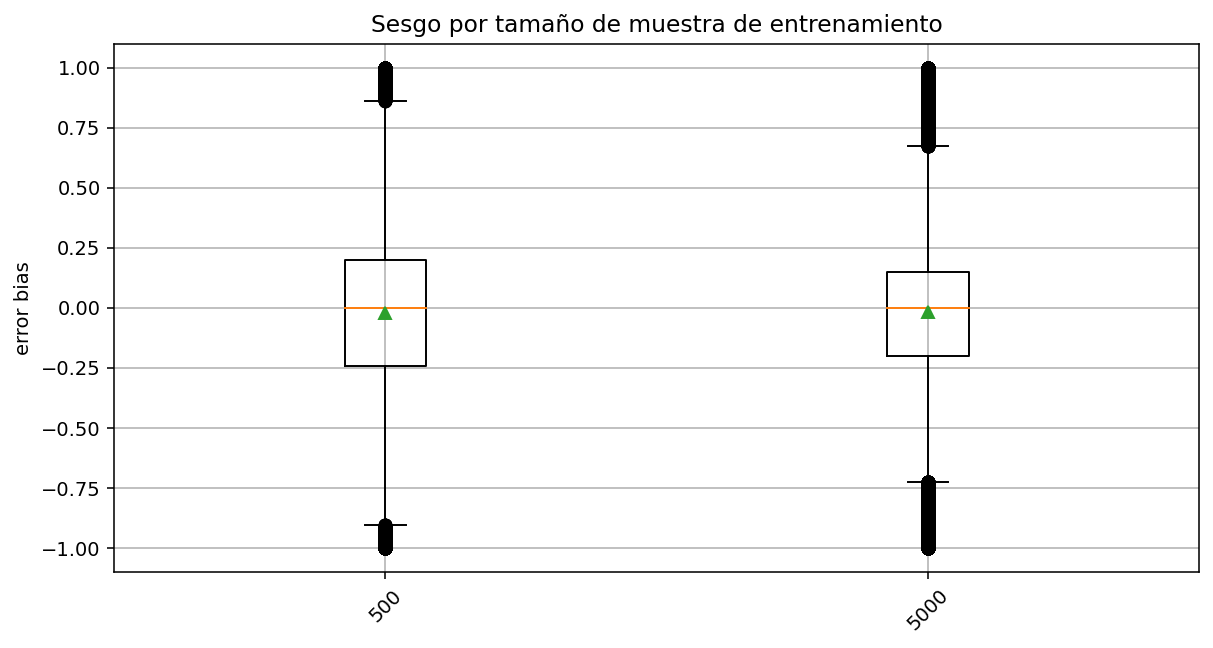

In [ ]:
groupby = ['Train n_samples']
method_names = stats_df.groupby(groupby).apply(np.array).index.tolist()
true_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Test prev'].apply(np.array)]
estim_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Estim test prev'].apply(np.array)]

qp.plot.binary_bias_global(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    title=f'Sesgo por tamaño de muestra de entrenamiento',
    savepath=f'./experiments/plots/global_bias_by_train_n_samples.png',
)

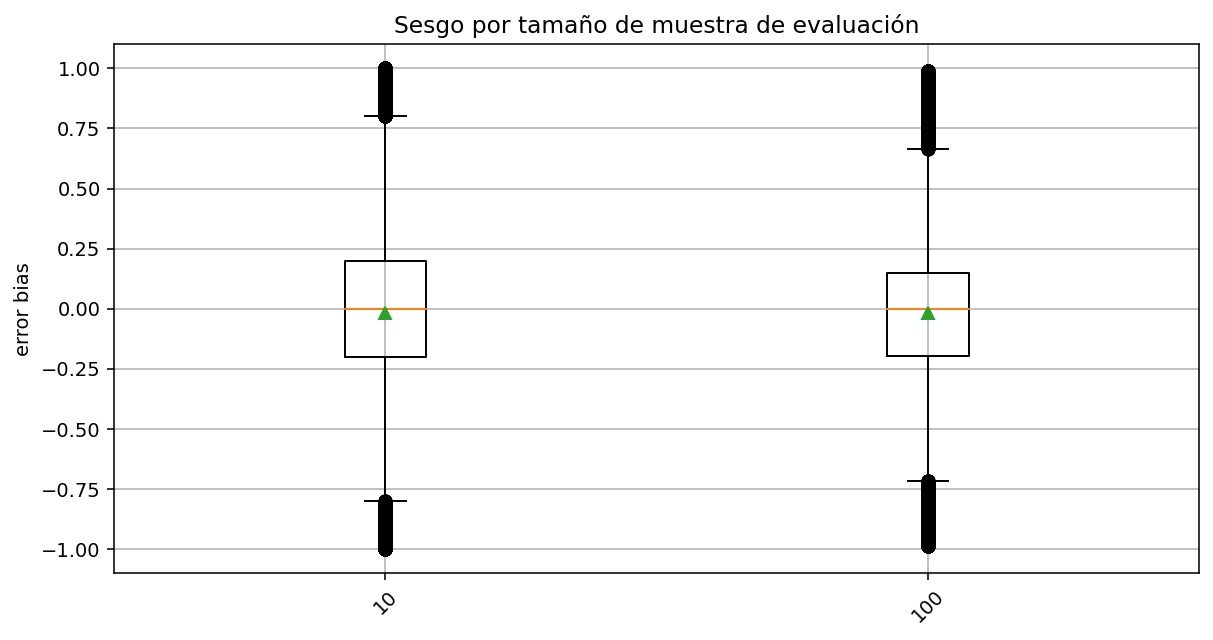

In [ ]:
groupby = ['Test n_samples']
method_names = stats_df.groupby(groupby).apply(np.array).index.tolist()
true_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Test prev'].apply(np.array)]
estim_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby(groupby)['Estim test prev'].apply(np.array)]

qp.plot.binary_bias_global(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    title=f'Sesgo por tamaño de muestra de evaluación',
    savepath=f'./experiments/plots/global_bias_by_test_n_samples.png',
)

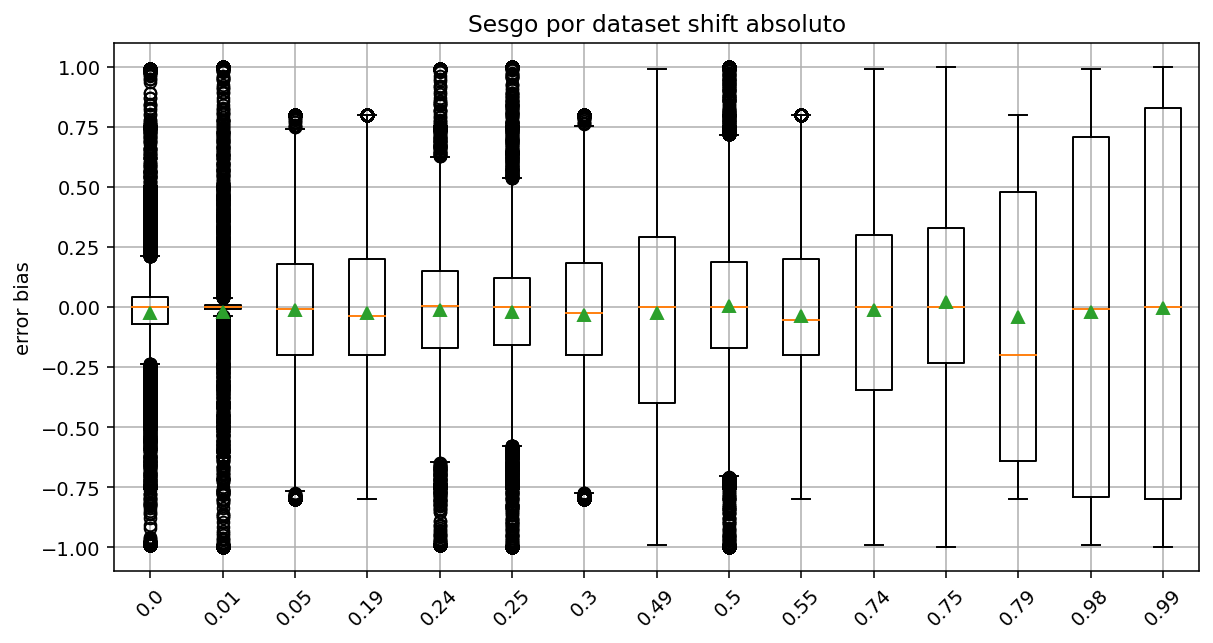

In [ ]:
method_names = stats_df.groupby('Dif prev abs').apply(np.array).index.tolist()
true_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby('Dif prev abs')['Test prev'].apply(np.array)]
estim_prevs = [np.concatenate(x).reshape(-1, 2) for x in stats_df.groupby('Dif prev abs')['Estim test prev'].apply(np.array)]

qp.plot.binary_bias_global(
    method_names=method_names,
    true_prevs=true_prevs,
    estim_prevs=estim_prevs,
    title=f'Sesgo por dataset shift absoluto',
    savepath=f'./experiments/plots/global_bias_by_dataset_shift_abs.png',
)

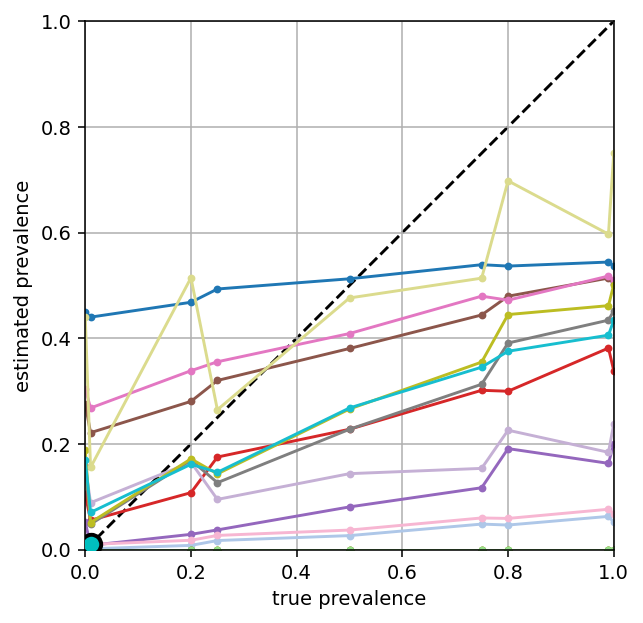

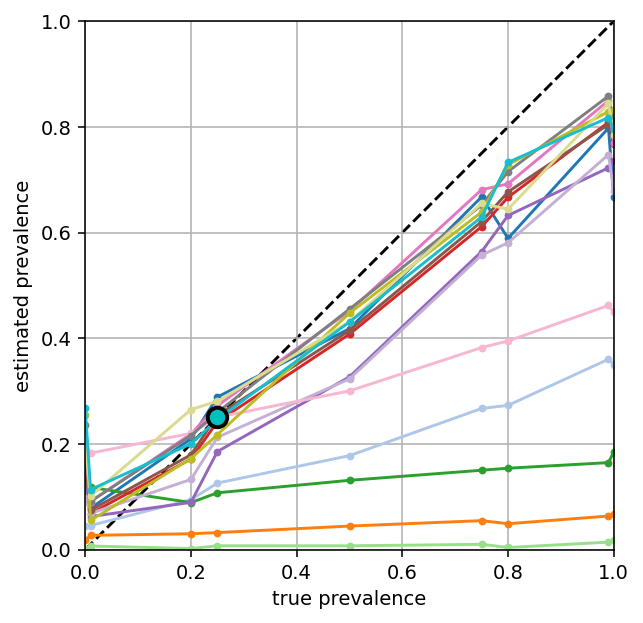

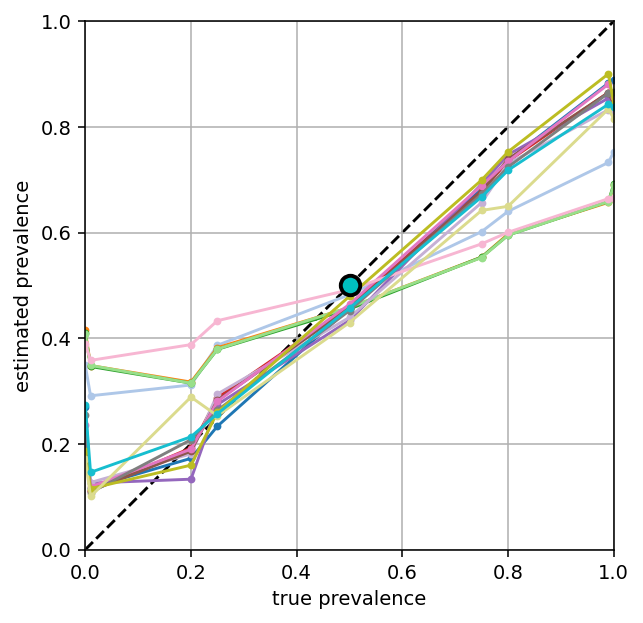

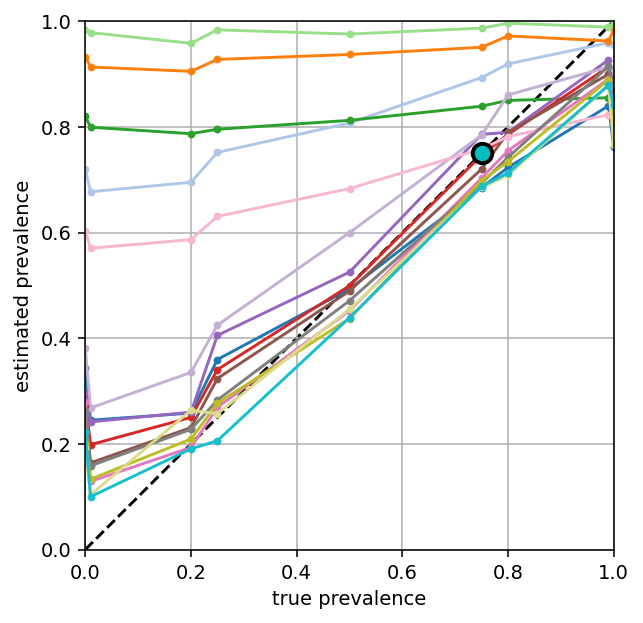

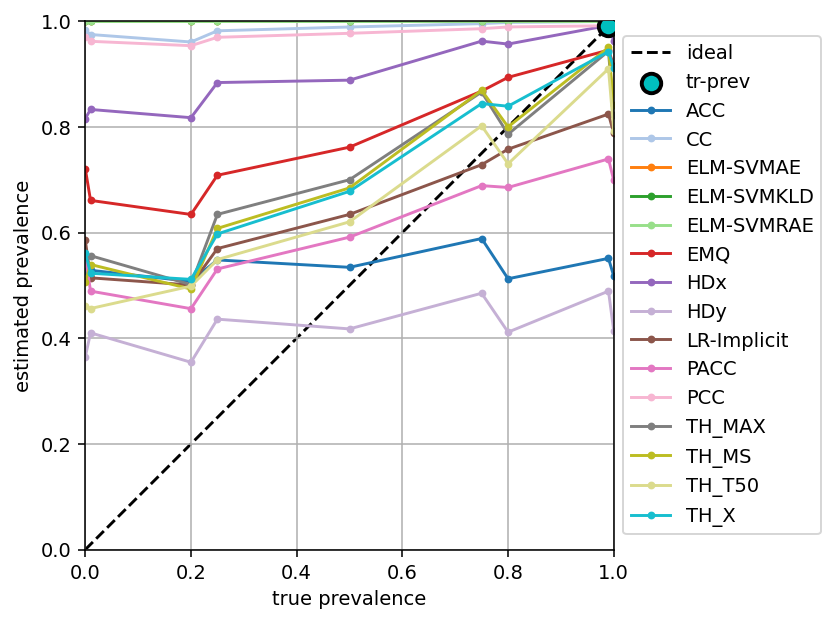

In [ ]:
groupby = ['Cuantificador']
step = 1/(config['trainset']['n_prevalences']-1)
train_prevs_class_1 = [x/(config['trainset']['n_prevalences']-1) for x in range(1, config['trainset']['n_prevalences']-1, 1)]
train_prevs_class_1 = [0.01] + train_prevs_class_1 + [0.99]
for train_prev_class_1 in train_prevs_class_1:
    mask = np.vstack(stats_df['Train prev'])[:, 1] == train_prev_class_1
    sub_stats = stats_df[mask]
    method_names = sub_stats.groupby(groupby).apply(np.array).index.tolist()
    true_prevs = [np.concatenate(x).reshape(-1, 2) for x in sub_stats.groupby(groupby)['Test prev'].apply(np.array)]
    estim_prevs = [np.concatenate(x).reshape(-1, 2) for x in sub_stats.groupby(groupby)['Estim test prev'].apply(np.array)]    
    train_prev = np.asarray([1-train_prev_class_1, train_prev_class_1])
    train_prevs = [train_prev]*len(method_names)
    plt.rcParams["figure.figsize"] = (10, 5)
    savepath = f'./experiments/plots/diagonal_by_cuantificator_{train_prev_class_1:.2f}.png'
    legend = True if f'{train_prev_class_1:.2f}'=='0.99' else False
    qp.plot.binary_diagonal(
        method_names=method_names,
        true_prevs=true_prevs,
        estim_prevs=estim_prevs,
        show_std=False,
        legend=legend,
        train_prev=train_prev,
        savepath=savepath,
    )

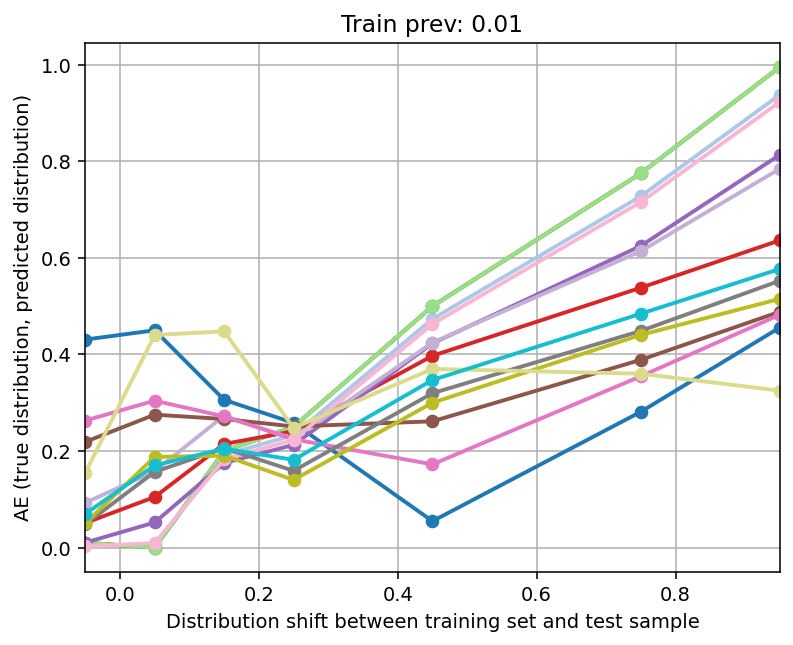

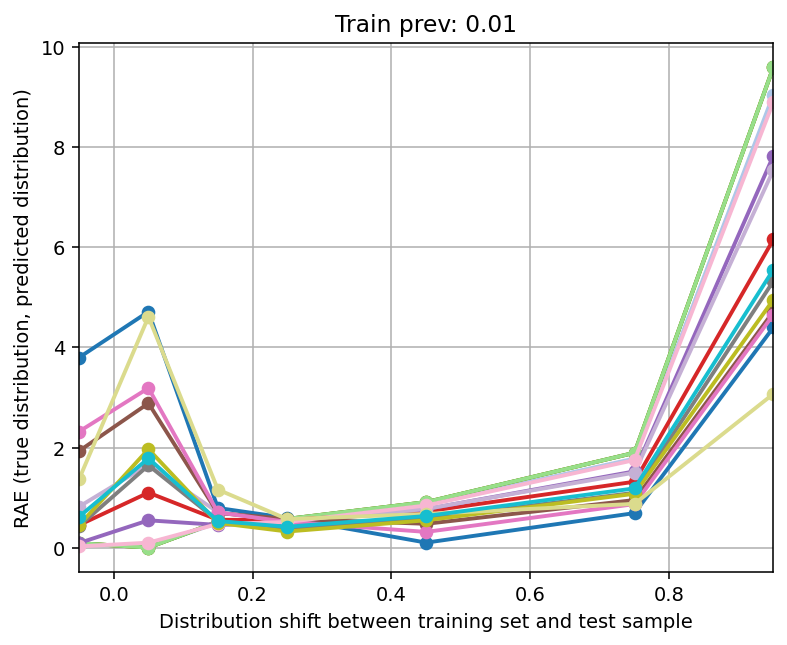

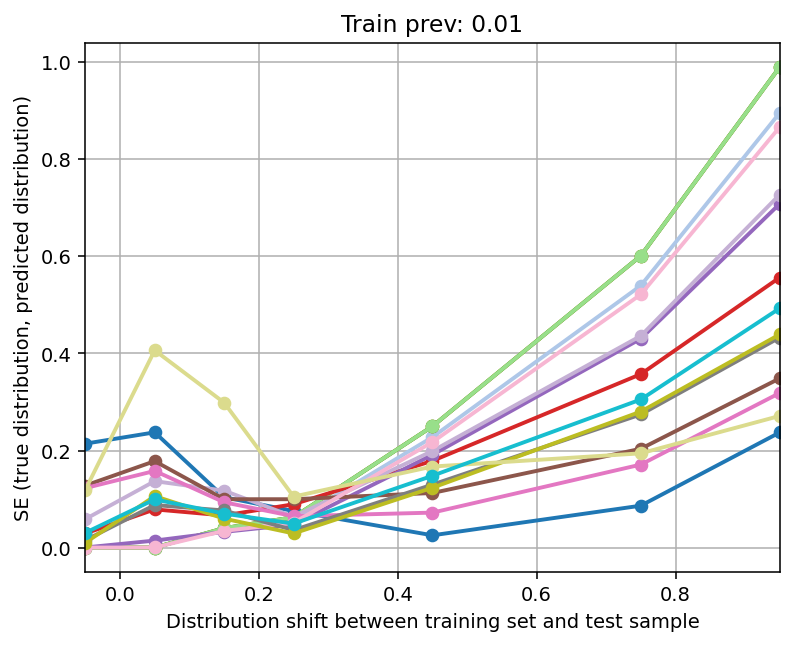

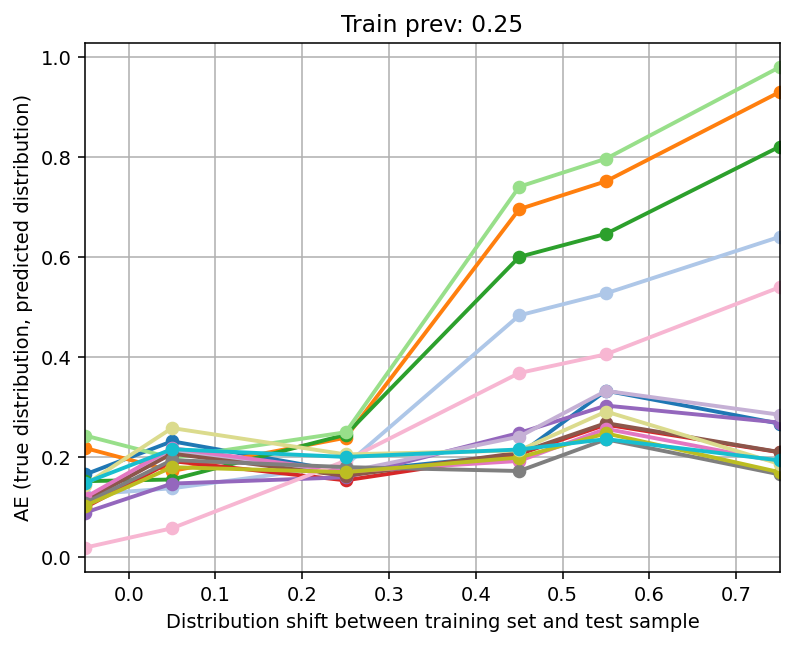

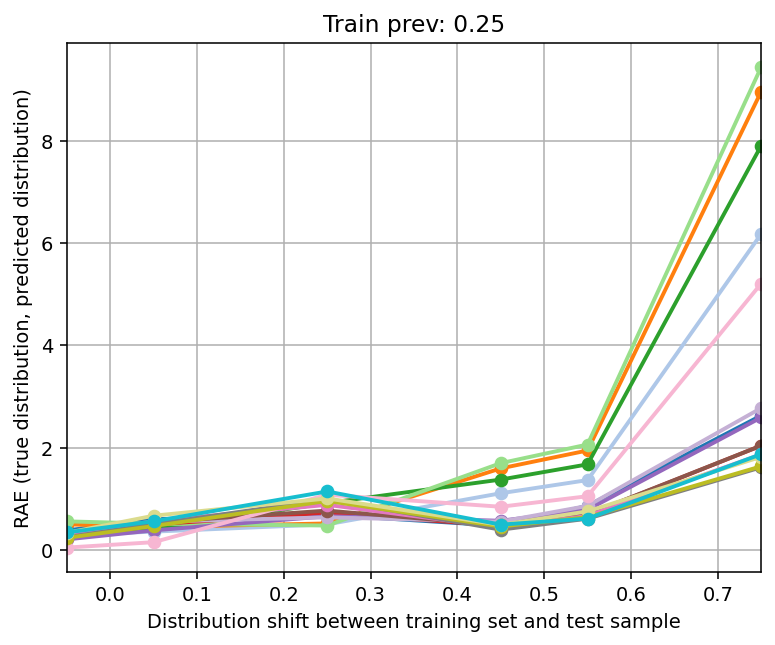

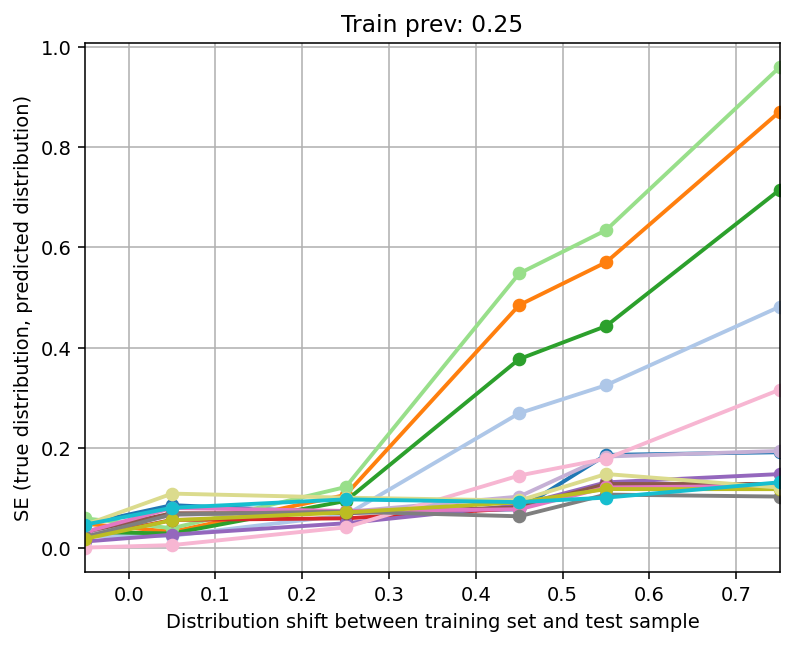

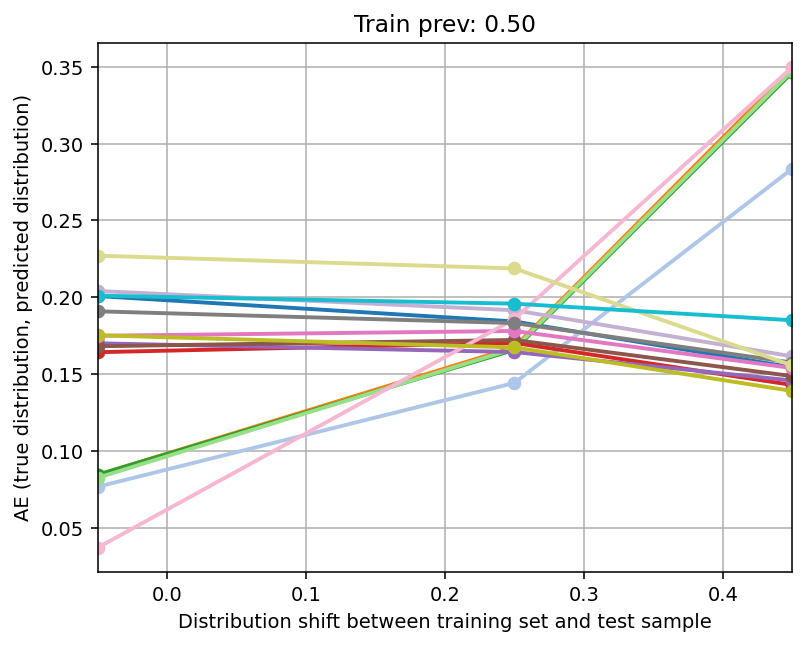

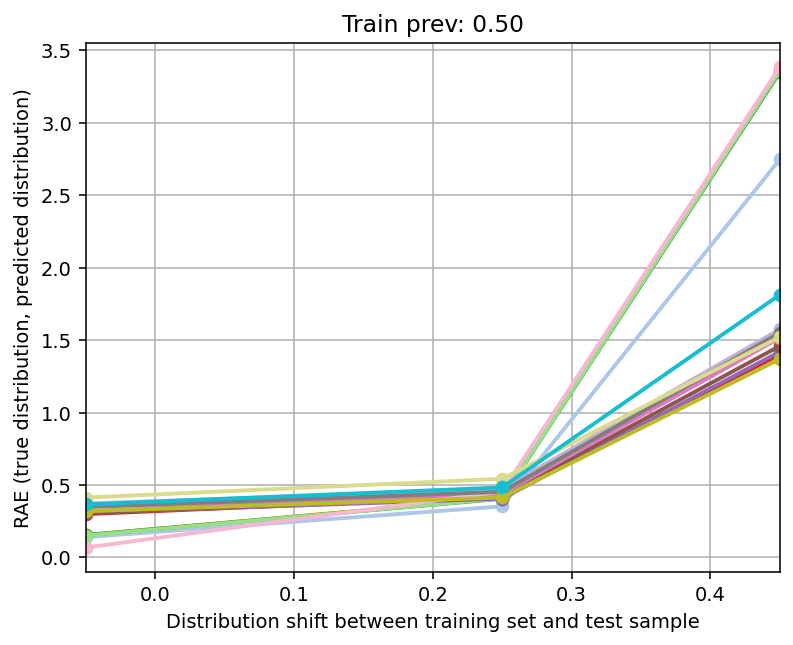

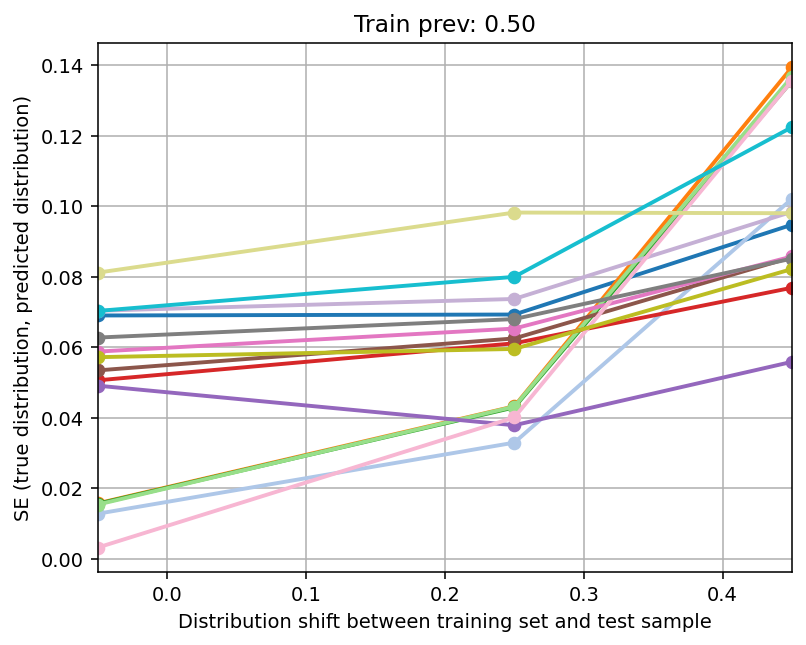

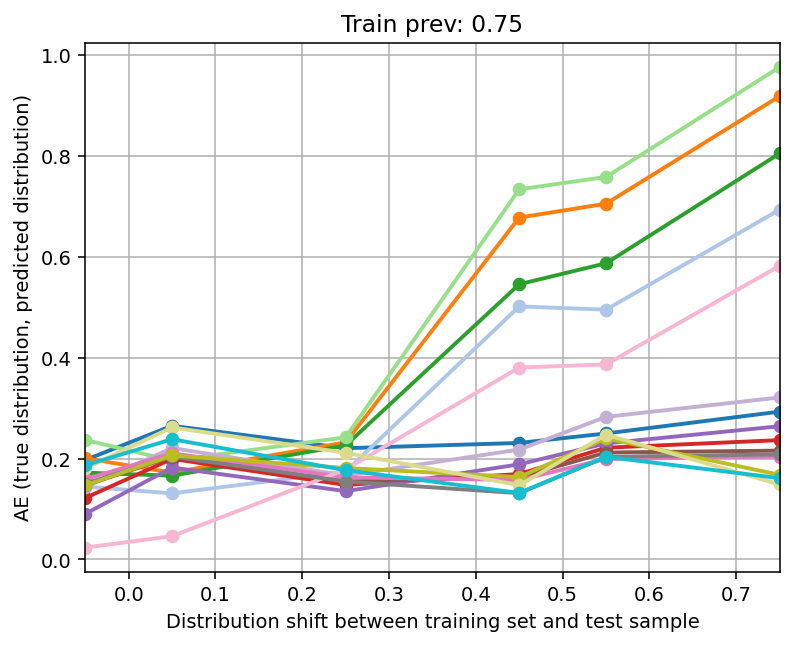

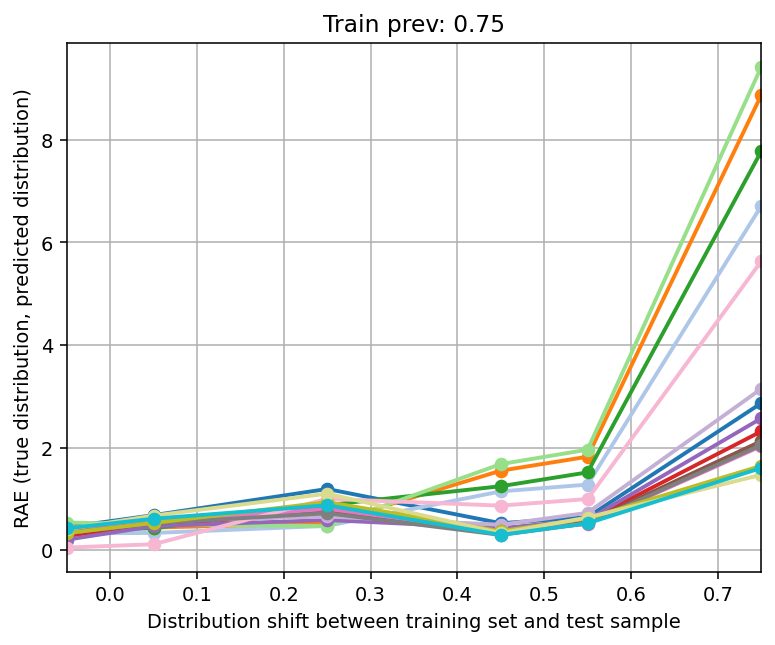

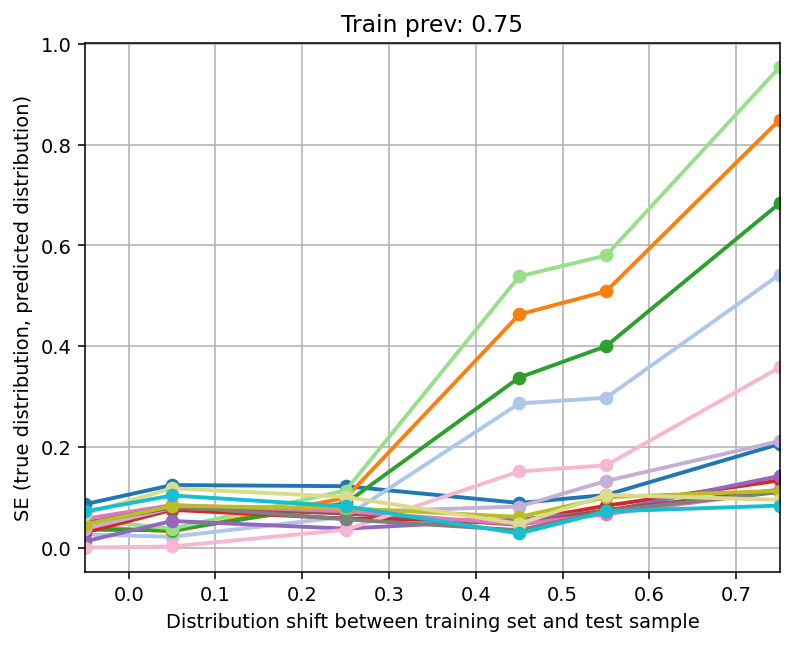

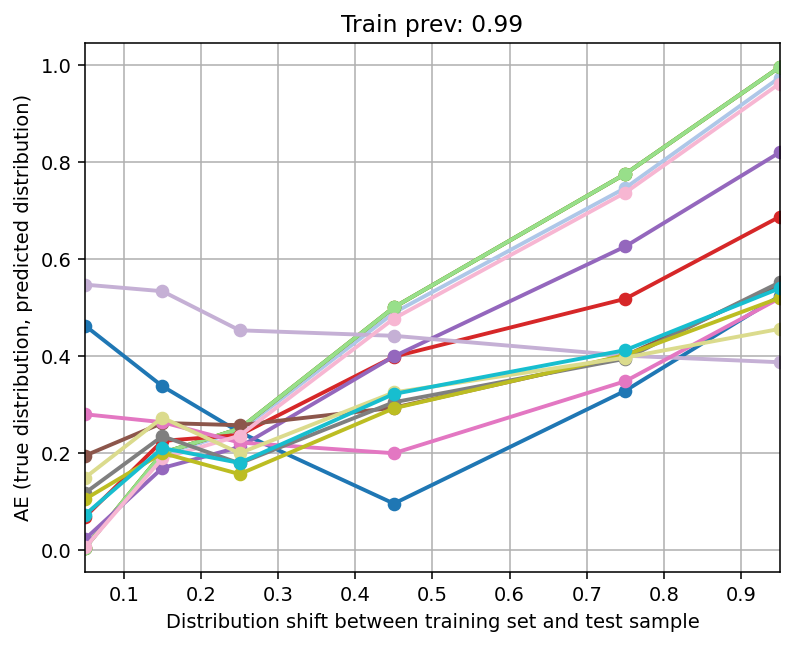

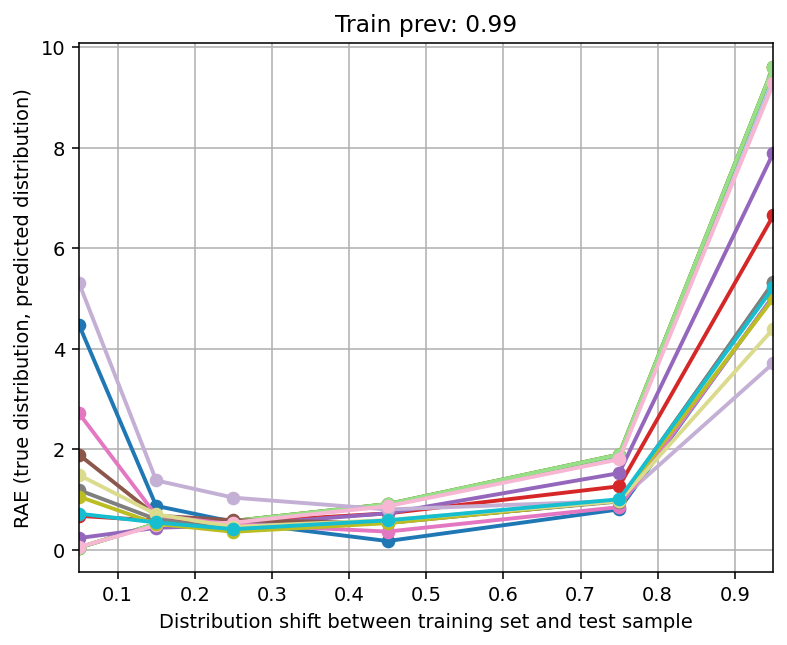

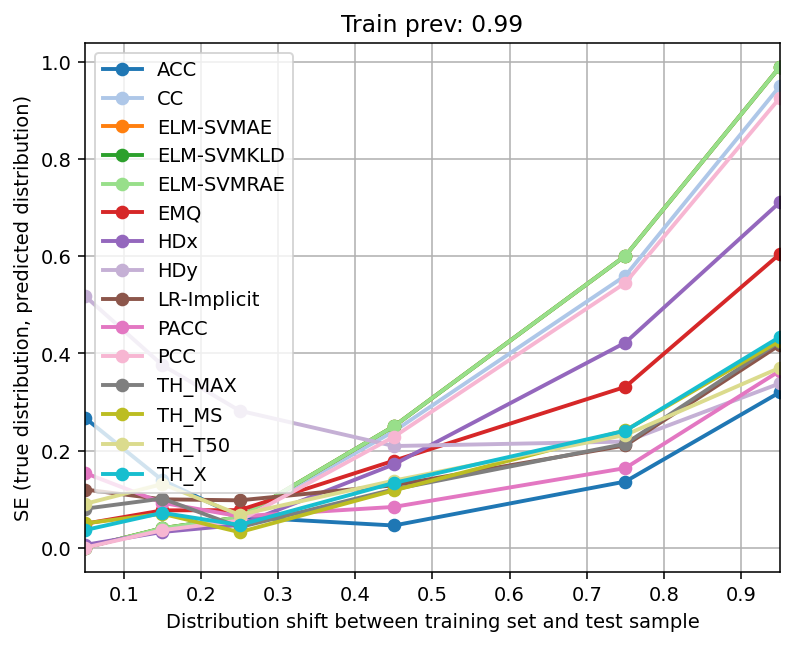

In [72]:
groupby = ['Cuantificador']
qp.environ["SAMPLE_SIZE"] = config['testset']['sample_sizes'][0]

step = 1/(config['trainset']['n_prevalences']-1)
train_prevs_class_1 = [x/(config['trainset']['n_prevalences']-1) for x in range(1, config['trainset']['n_prevalences']-1, 1)]
train_prevs_class_1 = [0.01] + train_prevs_class_1 + [0.99]
for train_prev_class_1 in train_prevs_class_1:
    mask = np.vstack(stats_df['Train prev'])[:, 1] == train_prev_class_1
    sub_stats = stats_df[mask]
    method_names = sub_stats.groupby(groupby).apply(np.array).index.tolist()
    true_prevs = [np.concatenate(x).reshape(-1, 2) for x in sub_stats.groupby(groupby)['Test prev'].apply(np.array)]
    estim_prevs = [np.concatenate(x).reshape(-1, 2) for x in sub_stats.groupby(groupby)['Estim test prev'].apply(np.array)]  
    train_prev = np.asarray([1-train_prev_class_1, train_prev_class_1])
    train_prevs = [train_prev]*len(method_names)
    plt.rcParams["figure.figsize"] = (8, 5)
    plt.rcParams["legend.loc"] = 'lower center'
    for metric in ('ae', 'rae', 'se'):
        savepath = f'./experiments/plots/drift_{metric}_{train_prev_class_1:.2f}.png'
        legend = True if f'{train_prev_class_1:.2f}'=='0.99' and metric=='se' else False
        qp.plot.error_by_drift(
            method_names=method_names,
            true_prevs=true_prevs,
            estim_prevs=estim_prevs,
            tr_prevs=train_prevs,
            error_name=metric,
            show_std=False,
            show_density=False,
            show_legend=legend,
            n_bins=10,
            title=f'Train prev: {(train_prev_class_1):.2f}',
            savepath=savepath,
        )


In [73]:
stats_lr = parsed_stats[parsed_stats['Cuantificador']=='LR-Implicit'].dropna(axis=1, how='all')
stats_pb = parsed_stats[parsed_stats['Cuantificador']!='LR-Implicit'].dropna(axis=1, how='all')

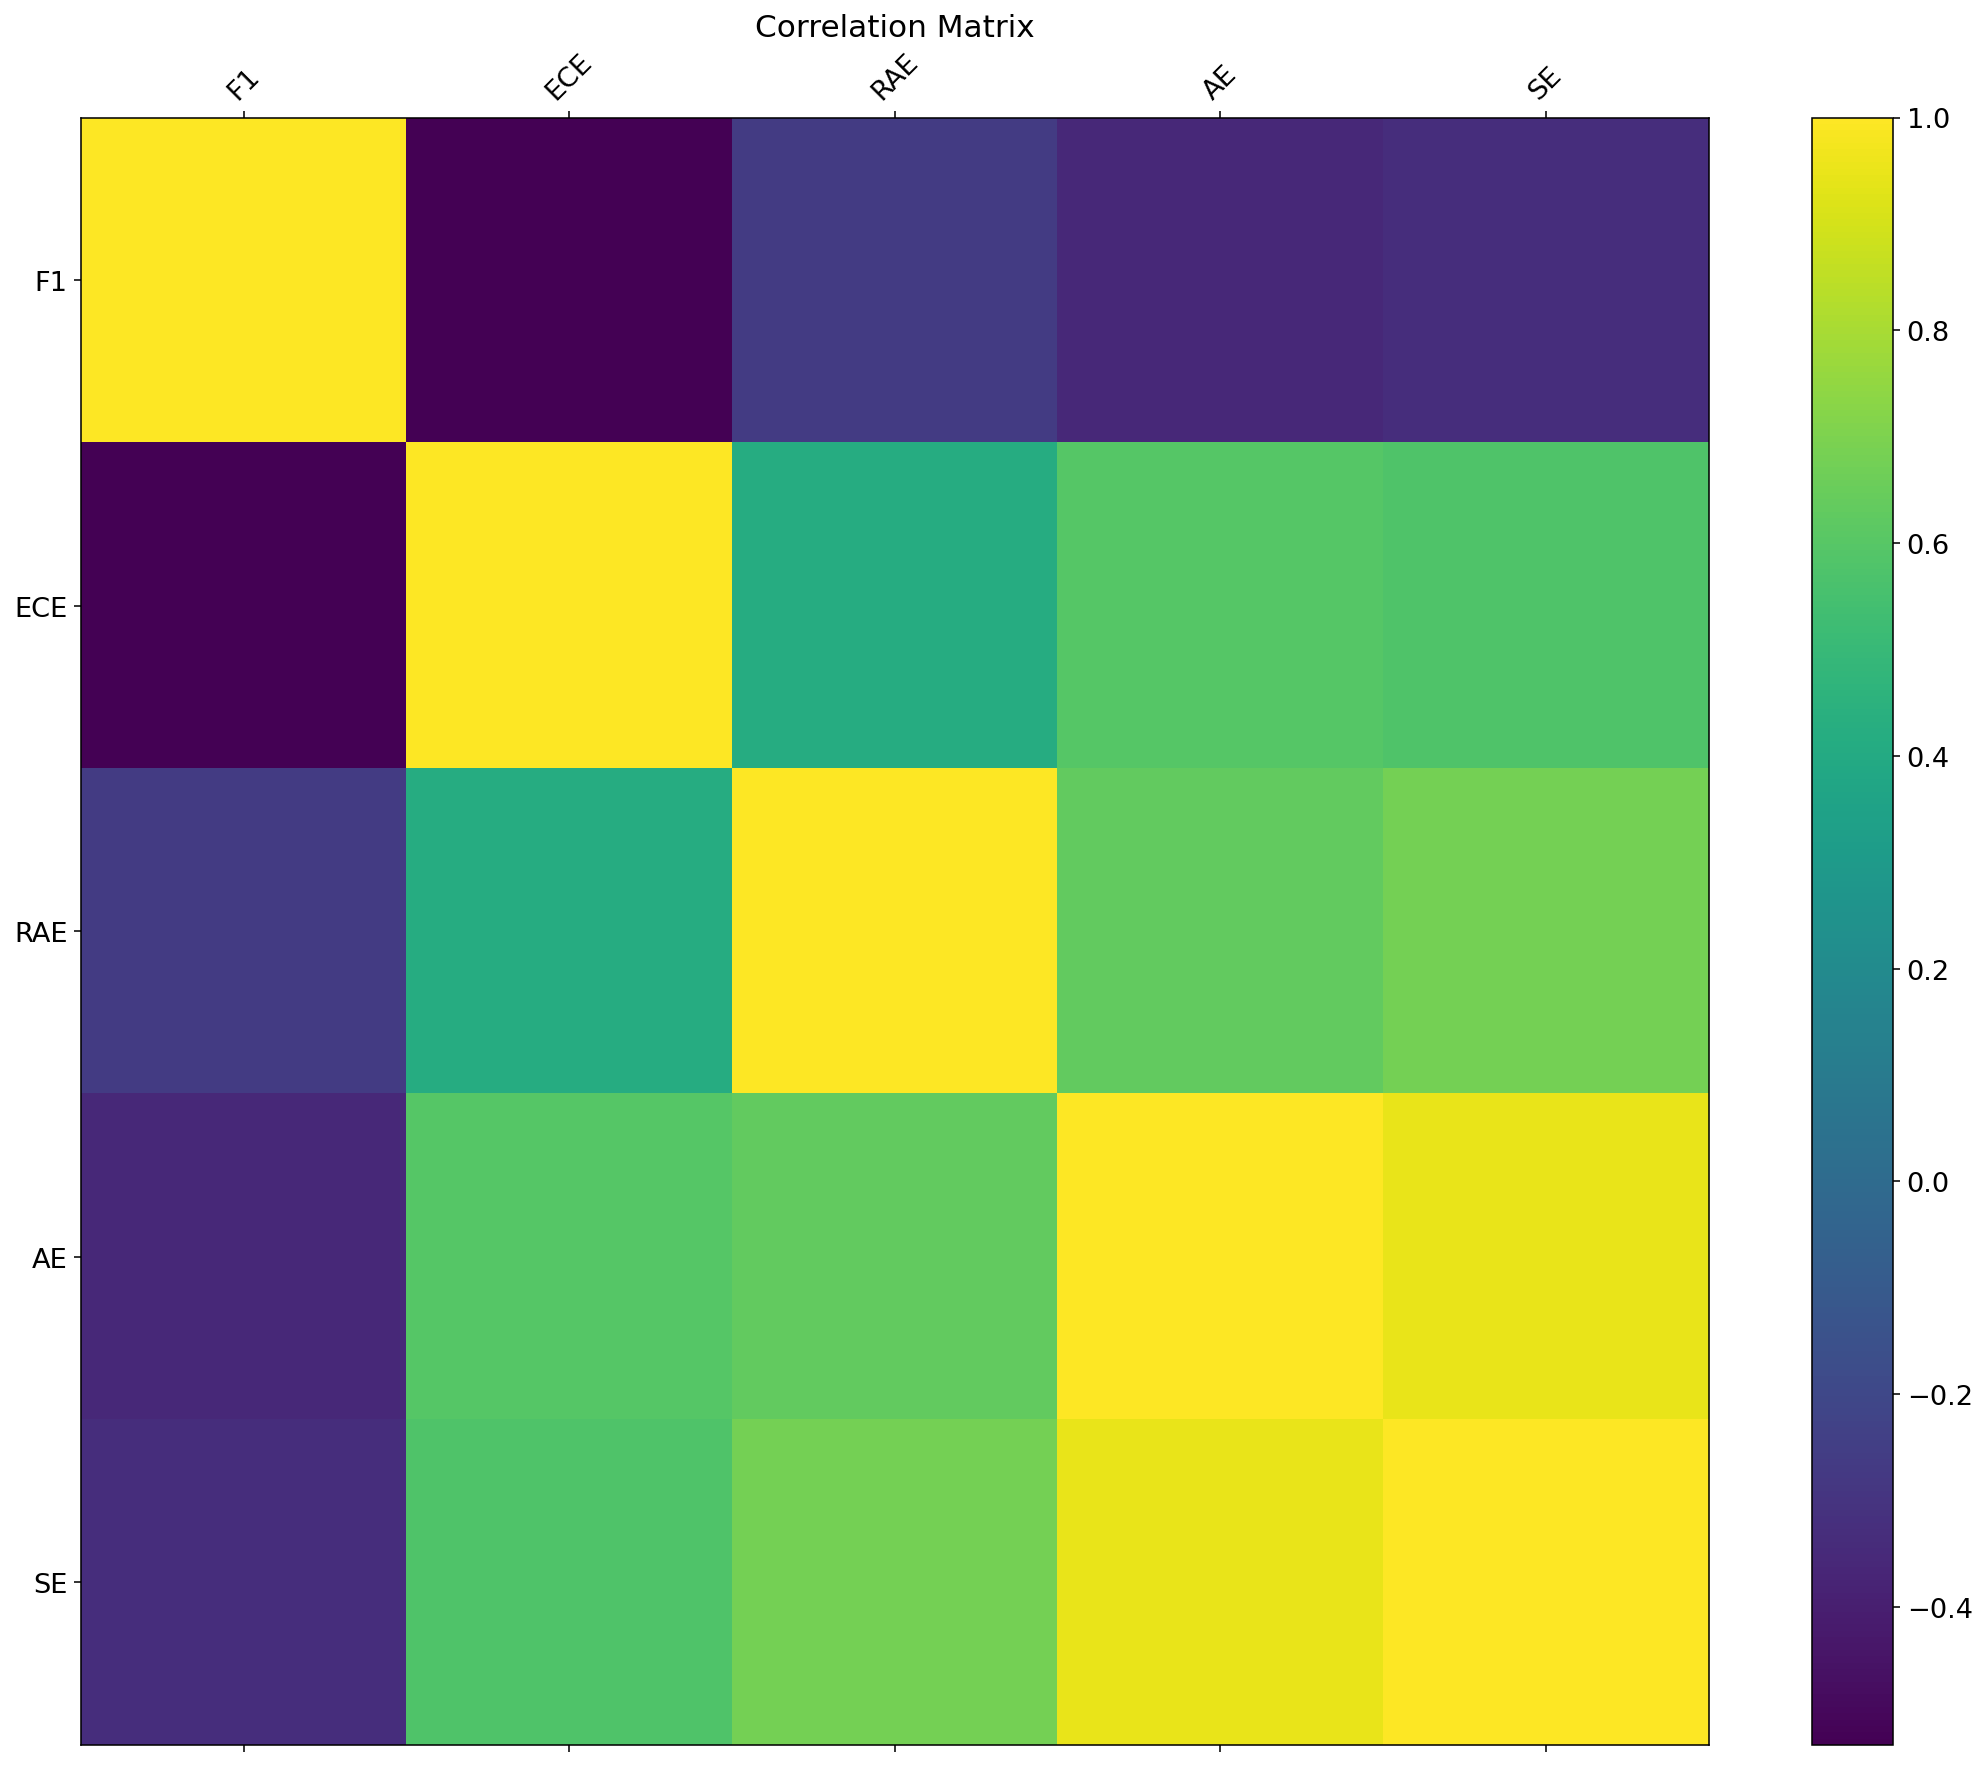

In [74]:
f = plt.figure(figsize=(19, 15))
corr_cols = ['F1', 'ECE', 'RAE', 'AE', 'SE']
df = stats_pb[stats_pb['Train prev +']==0.5][corr_cols]
corr = stats_pb[corr_cols].corr()
plt.matshow(corr, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()